## Implementation of Variable Elimination to approximate probability queries from a Bayesian Network.

In [1]:
import numpy as np
from calculations_helper import break_up_polytree, handle_dag_variable_elimination, join_distributions

def estimate_variable_elimination(queries: list[int], evidence: dict[int,bool], entire_network: dict) -> tuple[list[int], np.array]:
    """Given a Bayesian network and a list of query and evidence variables, return the probability distribution for all possible values of query variables

    Args:
        queries (list[int]): list of variables specified whose value probabilities we want to query
        evidence (list[tuple[int,bool]]): list of variables whose values are specified and hence affect query probabilities
        network (dict): underlying network which reveals probabilities of each node given its parents' values

    Returns:
        tuple[list[int],np.array]: probability distribution of possible combination values of each of the query variables (2^{#query variables}, 0 is all false and 2^{#query variables}-1 is all true)
    """
    dag_map, query_collections, evidence_collections = break_up_polytree(entire_network, queries, evidence)
    
    if len(dag_map) == 1:
        # only one directed acyclic graph
        return queries, handle_dag_variable_elimination(entire_network, queries, evidence)
    else:
        # each directed acyclic graph will output a probability distribution - we must join them all and keep track of the variables present
        reordered_queries = []
        prob_distributions = []
        for i, dag in dag_map.items():
            these_queries = query_collections[i]
            for v in these_queries:
                reordered_queries.append(v)
            this_evidence = {v:evidence[v] for v in evidence_collections[i]}
            prob_distributions.append(handle_dag_variable_elimination(dag, these_queries, this_evidence))
        return reordered_queries, join_distributions(prob_distributions)

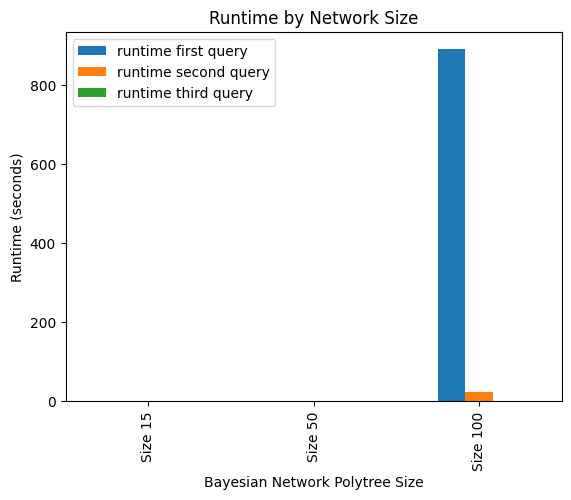

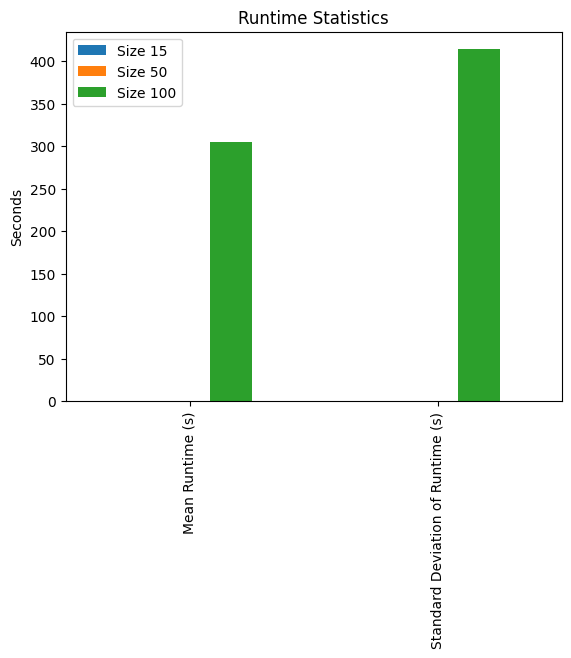

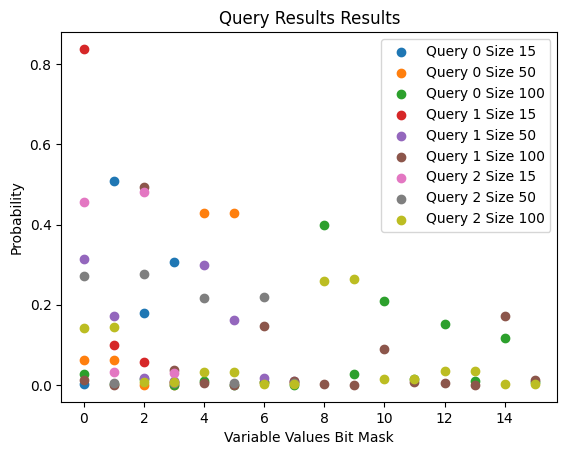

In [2]:
import json
import time

query_list = [[1, 3], [4, 5, 7], [2,6,10,12]]
evidence_list = [{2:False, 5:True}, {2:True, 3:False, 6:False}, {3:False, 4:False, 5:True, 15:True}]

times = [[],[],[]]
results = [[],[],[]]

for queries,evidence in zip(query_list,evidence_list):
    with open('small_polytree.json') as f:
        bayesian_network = json.load(f)
        start_time = time.perf_counter()
        results[0].append(estimate_variable_elimination(queries, evidence, bayesian_network))
        end_time = time.perf_counter()
        times[0].append(end_time-start_time)
    with open('big_polytree.json') as f:
        bayesian_network = json.load(f)
        start_time = time.perf_counter()
        results[1].append(estimate_variable_elimination(queries, evidence, bayesian_network))
        end_time = time.perf_counter()
        times[1].append(end_time-start_time)
    with open('giant_polytree.json') as f:
        bayesian_network = json.load(f)
        start_time = time.perf_counter()
        results[2].append(estimate_variable_elimination(queries, evidence, bayesian_network))
        end_time = time.perf_counter()
        times[2].append(end_time-start_time)

import pandas as pd 
import matplotlib.pyplot as plt 
  
# DataFrame to represent opening , closing, high  
# and low prices of a stock for a week 
runtimes = pd.DataFrame({'runtime first query': [t[0] for t in times],
                             'runtime second query': [t[1] for t in times],
                             'runtime third query': [t[2] for t in times]}, 
                            index=["Size 15", "Size 50", "Size 100"])

runtimes.plot(kind='bar')
plt.title("Runtime by Network Size")
plt.xlabel("Bayesian Network Polytree Size")
plt.ylabel("Runtime (seconds)")
plt.show()

runtimes_by_graph_size = pd.DataFrame({'Size 15': [np.mean(np.array([t for t in times[0]])), np.std(np.array([t for t in times[0]]))],
                                       'Size 50': [np.mean(np.array([t for t in times[1]])), np.std(np.array([t for t in times[1]]))],
                                       'Size 100': [np.mean(np.array([t for t in times[2]])), np.std(np.array([t for t in times[2]]))]},
                                       index=["Mean Runtime (s)", "Standard Deviation of Runtime (s)"])

runtimes_by_graph_size.plot(kind='bar')
plt.title("Runtime Statistics")
plt.ylabel("Seconds")
plt.show()

fig, ax = plt.subplots()
for i, r in enumerate(results):
    # iterate over queries
    for j, graph_size in enumerate([15,50,100]):
        x = r[j][1]
        y = range(len(x))
        ax.scatter(y, x, label=f"Query {i} Size {graph_size}")

ax.legend()
plt.title("Query Results Results")
plt.xlabel("Variable Values Bit Mask")
plt.ylabel("Probability")
plt.show()